In [354]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.integrate import solve_ivp
plt.style.use('seaborn-darkgrid')
import datetime
from copy import deepcopy
from scipy.stats import norm
from scipy.optimize import differential_evolution
import pdb
from IPython.core.display import HTML
from math import ceil
from ipywidgets import interact, interactive, fixed, interact_manual

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [70]:
class DataFetcher:
    def __init__(self, url="https://api.covid19india.org/data.json"):
        self.url = url
        self.json_data = None
        self.cases_time_series = None
        
    def fetch(self):
        r = requests.get(url=self.url)
        self.json_data = r.json()
        
        # Get the fields
        fields = list(self.json_data['cases_time_series'][0].keys())
        self.cases_time_series = {}
        
        for field in fields:
            if field == 'date':
                self.cases_time_series[field] = [x[field] for x in self.json_data['cases_time_series']]
            else:
                self.cases_time_series[field] = np.array([float(x[field]) for x in self.json_data['cases_time_series']])
        
    def train_data(self, threshold):
        self.fetch()
        index = np.where(self.cases_time_series["totaldeceased"] > threshold)[0][0]
        startdate = self.cases_time_series["date"][index]
        return self.cases_time_series["totaldeceased"][index:], startdate

In [71]:
class DataFetcherState:
    """Fetch data for all states"""
    
    def __init__(self):
        self.data = None
        self.raw_data = None
    
    def fetch(self):
        # Fetch the raw data
        r = requests.get(url="https://api.covid19india.org/states_daily.json")
        self.raw_data = r.json()
        self.data = {}
        
        # Iterate over the days and record the data
        for entry in self.raw_data['states_daily']:
            status = entry['status'].lower()
            for state in entry:
                if state == "date" or state == "status":
                    continue
                    
                if state not in self.data:
                    # Initialize this state
                    self.data[state] = {
                        'deceased' : [],
                        'recovered': [],
                        'confirmed': []
                    }
                
                # Append the data
                self.data[state][status].append(entry[state])
                
    def start_date(self):
        return self.raw_data['states_daily'][0]['date']

The SEIR model is defined as 

$$
\frac{dS}{dt} = -\frac{RIS}{T_{inf}} 
$$ 


$$
\frac{dE}{dt} = \frac{RIS}{T_{inf}}  - \frac{E}{T_{inc}} 
$$

$$
\frac{dI}{dt} = \frac{E}{T_{inc}}  - \frac{I}{T_{inf}} 
$$

$$
\frac{dX}{dt} = \frac{I}{T_{inf}} 
$$

$S, E, I, X$ are respectively the number of people that are susceptible, exposed, infected and removed. $R$ is the time-dependent value of the basic reproduction number. $T_{inf}$, $T_{inc}$ are the average infection and incubation periods respectively. $R$ can be related to social distancing data as follows

$$
R =  \lambda(\Delta I_{r} + \Delta I_{g} + \Delta I_{p} + \Delta I_{t} + \Delta I_{w})
$$

here $\lambda$ is a tunable parameter and other values are

* $\Delta I_{r}$ - retail and recreation
* $\Delta I_{g}$ - grocery and pharmacy
* $\Delta I_{p}$ - parks 
* $\Delta I_{t}$ - transit stations
* $\Delta I_{w}$ - workplaces


In [285]:
# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (E / T_inc)

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (E / T_inc) - (I / T_inf)

# Recovered/deceased equation
def dR_dt(I, T_inf):
    return (I / T_inf)

def SEIR_model(t, y, R_t, T_inf, T_inc):
    
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
    
    S, E, I, R = y
    S_out = S + dS_dt(S, I, reproduction, T_inf)
    E_out = E + dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = I + dI_dt(I, E, T_inc, T_inf)
    R_out = R + dR_dt(I, T_inf)

    return [S_out, E_out, I_out, R_out]

def SIR_model(t, y, R_t, case_mortality, T_inf, T_inc):
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
    
    S, I, R = y
    S_out = S + dS_dt(S, I, reproduction, T_inf)
    I_out = I + dI_dt(I, 0, T_inc, T_inf) - dS_dt(S, I, reproduction, T_inf)
    R_out = R + dR_dt(I, T_inf) * case_mortality

    return [S_out, I_out, R_out]

In [286]:
# N = 100000  # Population size
# n_infected = 1
# max_days = 200

# # State at time = 0 for SEIR model
# a = (N - n_infected)/ N
# b = 0
# c = n_infected / N
# d = 0.

In [113]:
# def plot_model(solution, title='SEIR model'):
#     sus, exp, inf, rec = solution.y

#     f = plt.figure(figsize=(8,5)) 
#     plt.plot(sus, 'b', label='Susceptible');
#     plt.plot(exp, 'y', label='Exposed');
#     plt.plot(inf, 'r', label='Infected');
#     plt.plot(rec, 'c', label='Recovered/deceased');
#     plt.title(title)
#     plt.xlabel("Days", fontsize=10);
#     plt.ylabel("Fraction of population", fontsize=10);
#     plt.legend(loc='best');

## Check Equations
R_0 is taken as a constant; check if the equations are correct <br/>
Parameters taken from https://gabgoh.github.io/COVID/index.html

## Fitting with real data - NYC


In [36]:
# Fetch data from NYC
! rm time_series_covid19_deaths_US.csv*
! wget -nv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv

raw_data_us = pd.read_csv("time_series_covid19_deaths_US.csv")
start_date = datetime.date(2020, 1, 22)
date_format = "%-m/%-d/%y"

# Extract NYC time_series data
deaths_time_series_nyc = []
date = deepcopy(start_date)
df_nyc = raw_data_us[raw_data_us['Combined_Key'].str.contains("New York City")]
df_nyc_cols = df_nyc.columns.values

while date.strftime(date_format) in df_nyc_cols:
    deaths_time_series_nyc.extend(df_nyc[date.strftime(date_format)].values)
    date = date + datetime.timedelta(days=1)

deaths_time_series_nyc = np.array(deaths_time_series_nyc)
deaths_time_series_nyc[1:] = np.diff(deaths_time_series_nyc)

2020-05-27 02:42:01 URL:https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv [1177355/1177355] -> "time_series_covid19_deaths_US.csv" [1]


In [76]:
# start_date_sd = datetime.date(2020, 2, 15)
# df_sd = pd.read_csv("Global_Mobility_Report.csv")
# df_sd = df_sd[df_sd['country_region_code'] == 'US']

# counties = ["New York County", "Kings County", "Bronx County", "Queens County"]
# sd_data = 
# df_sd[df_sd['sub_region_2'] == "Kings County"]

In [126]:
def smoothen(X, std):
    result = np.zeros_like(X)
    
    for i, _ in enumerate(X):
        norm_factor = 0
        for j, _X in enumerate(X):
            val = norm.pdf(j, loc=i, scale=std)
            result[i] += _X * val
            norm_factor += val
        result[i] /= norm_factor
    
    return result

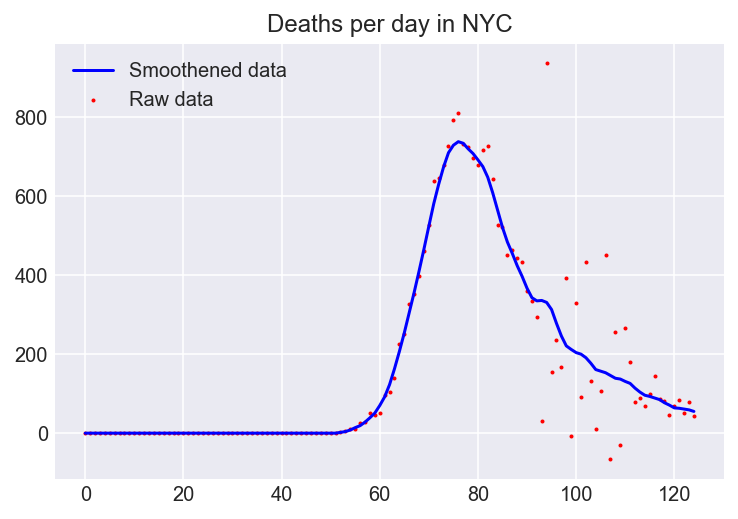

In [347]:
# Data visualization
smooth_data_nyc = smoothen(deaths_time_series_nyc, 2)

plt.scatter(np.arange(smooth_data_nyc.shape[0]), deaths_time_series_nyc, label="Raw data", s=1, c='red')
plt.plot(smooth_data_nyc, label="Smoothened data", c='blue')
plt.legend()
plt.title("Deaths per day in NYC")
plt.show()

In [304]:
def rmse_loss(x, y):
    return np.sqrt(np.mean(np.square(x - y)))

In [305]:
def simple_seir(t_max, pop, I_init, R):
    result = np.zeros(t_max + 1, dtype=float)
    result[0] = 0

    S = 1
    E = 0
    I = I_init
    X = 0

    for t in range(1, t_max + 1):
        S, E, I, X = SEIR_model(t, [S, E, I, X], R, T_inf, T_inc)
        result[t] = X 
    
    result[1:] = np.diff(result)
    return result * pop

In [318]:
def simple_sir(t_max, pop, I_init, R, case_mortality, T_inf):
    result = np.zeros(t_max + 1, dtype=float)
    result[0] = 0

    S = 1
    I = I_init
    X = 0

    for t in range(1, t_max + 1):
        S, I, X = SIR_model(t, [S, I, X], R, case_mortality, T_inf, 1)
        result[t] = X 
    
    result[1:] = np.diff(result)
    return result * pop

In [319]:
def run_model(*params, return_preds=False):
    model, loss_fun, daily_deaths = params[-3:]
    
    offset = int(params[0][0])
    t_max = daily_deaths[offset:].shape[0] - 1
    preds = model(t_max, *params[0][1:])

    loss = loss_fun(preds, daily_deaths[offset:])
    
    if not return_preds:
        return loss
    else:
        return loss, preds

In [332]:
def fit_model(model, loss_fun, daily_deaths, bounds, verbose=True):

    def print_progress(xk, convergence=0):                
        if verbose:
            np.set_printoptions(
                formatter={
                    'float': lambda x: "{:.1e}".format(x)
                }
            )

            if xk.shape[0] > 6:
                print("x0: {} conv: {:.3e}".format(xk[:6], convergence), end="\r")
            else:
                print("x0: {} conv: {:.3e}".format(xk, convergence), end="\r")


    result = differential_evolution(run_model,
                                    args=(model, loss_fun, daily_deaths),
                                    bounds=bounds,
                                    callback=print_progress)

    print(result.message)
    return result.x

In [333]:
def get_model_stats(model, loss_fun, data, breakpoints, plot_title, bounds, param_cols):
    df = pd.DataFrame()
    df['Breakpoint'] = []
    df['Loss']       = []
    
    
    for col in param_cols:
        df[col] = []
    
    time_values = np.arange(data.shape[0])
    
    col_num = 3
    row_num = ceil(len(breakpoints) / col_num)
    
    fig, axs = plt.subplots(row_num, col_num, figsize=(15, 8), sharex=True, sharey=True)
    
    for b, ax in zip(breakpoints, axs.flat):
        params = fit_model(model, loss_fun, data[:b], bounds, verbose=True)
        offset = int(params[0])
        
        loss, preds = run_model(params, model, loss_fun, data, return_preds=True)
        
        ax.plot(time_values[offset:], preds, label="Projected deaths")
        ax.scatter(time_values[:b], data[:b], s=2, c='green', label="Used points")
        ax.scatter(time_values[b:], data[b:], s=2, c='red', label="Unused points")
        ax.set_title("NYC | {} days".format(b))
        ax.set_xlabel("Days")
        ax.set_ylabel("Deaths")
        ax.legend()
        
        
        df_dict = {
            "Breakpoint": [b],
            "Loss"      : [loss],
        }

        for i, col in enumerate(param_cols):
            df_dict[col] = [params[i]]

        df = df.append(pd.DataFrame(df_dict))
    
    fig.suptitle(plot_title, fontsize=15)
    fig.tight_layout(pad=3.0)
    return df

<h2>Fitting a SIR model without social distancing</h2>

Simple SIR model to test the code and get baseline statistics

$$
\frac{dS}{dt} = -\frac{RIS}{T_{inf}} 
$$ 


$$
\frac{dI}{dt} = \frac{RIS}{T_{inf}}   - \frac{I}{T_{inf}} 
$$

$$
\frac{dX}{dt} = \frac{\lambda I}{T_{inf}} 
$$

Here, $R$ is the reproduction number, $\lambda$ is the fraction of people who die (it is assumed that people die and recover at the same rate). The tunable parameters are 

* $R$ - (fixed) reproduction number 
* $\lambda$ - the fraction of recovered people who die
* $\texttt{offset}$ - from where to start the prediction, 
* $I_0$ - the initial number of infected people
* $T_{inf}$ - the average time for which a person remains infected (regardless of whether they die or not)

We can see a problem here -- the SIR model is not able to predict a long tail for the deaths. This is because in the absence of lockdown measures, the disease spreads through the population rapidly, infecting everyone in a short time. Lockdown measures serve to clamp down on the transmissibility of the disease.

In [342]:
def plot_sir(offset, pop, I_init, R, mort, T_inf, daily_deaths):
    time_values = np.arange(daily_deaths.shape[0])
    t_max = time_values[offset:].shape[0] - 1
    
    preds = simple_sir(t_max, pop, I_init, R, mort, T_inf)
    
    
    plt.plot(time_values[offset:], preds, label="Projected deaths")
    plt.plot(time_values, daily_deaths, '.', label="Actual deaths")
    plt.title("Interactive SIR plot")
    plt.show()

interact(plot_sir, offset=10, pop=82206, I_init=0.000197, R=3, mort=0.105688, T_inf=6, daily_deaths=fixed(smooth_data_nyc))

interactive(children=(IntSlider(value=10, description='offset', max=30, min=-10), IntSlider(value=82206, descr…

<function __main__.plot_sir(offset, pop, I_init, R, mort, T_inf, daily_deaths)>

Optimization terminated successfully.4.1e-03 6.0e+00] conv: 1.007e+00
Optimization terminated successfully.1.3e-02 6.2e+00] conv: 6.376e+00
Optimization terminated successfully.4.2e-03 6.9e+00] conv: 1.140e+00
Optimization terminated successfully.5.1e-03 7.5e+00] conv: 1.007e+00
Optimization terminated successfully.2.1e-02 7.9e+00] conv: 1.001e+00
Optimization terminated successfully.1.7e-02 8.0e+00] conv: 1.016e+00


,Breakpoint,Loss,offset,pop,I_init,R,mort,T_inf
0,70.0,67.520128,0.673061,4.538705e+06,2.532829e-08,2.599780,0.004056,6.000004
0,80.0,78.489673,31.555340,1.315375e+06,5.221599e-05,2.599792,0.013373,6.187844
0,90.0,53.181354,35.579381,4.738055e+06,2.546967e-04,2.599202,0.004220,6.912254
0,100.0,35.926700,0.247859,4.162174e+06,4.937221e-07,2.599797,0.005130,7.500506
0,110.0,35.322231,14.842699,1.034132e+06,1.246624e-05,2.597246,0.021400,7.888903
0,120.0,35.302172,16.980172,1.283730e+06,2.019538e-05,2.600000,0.017395,8.000000


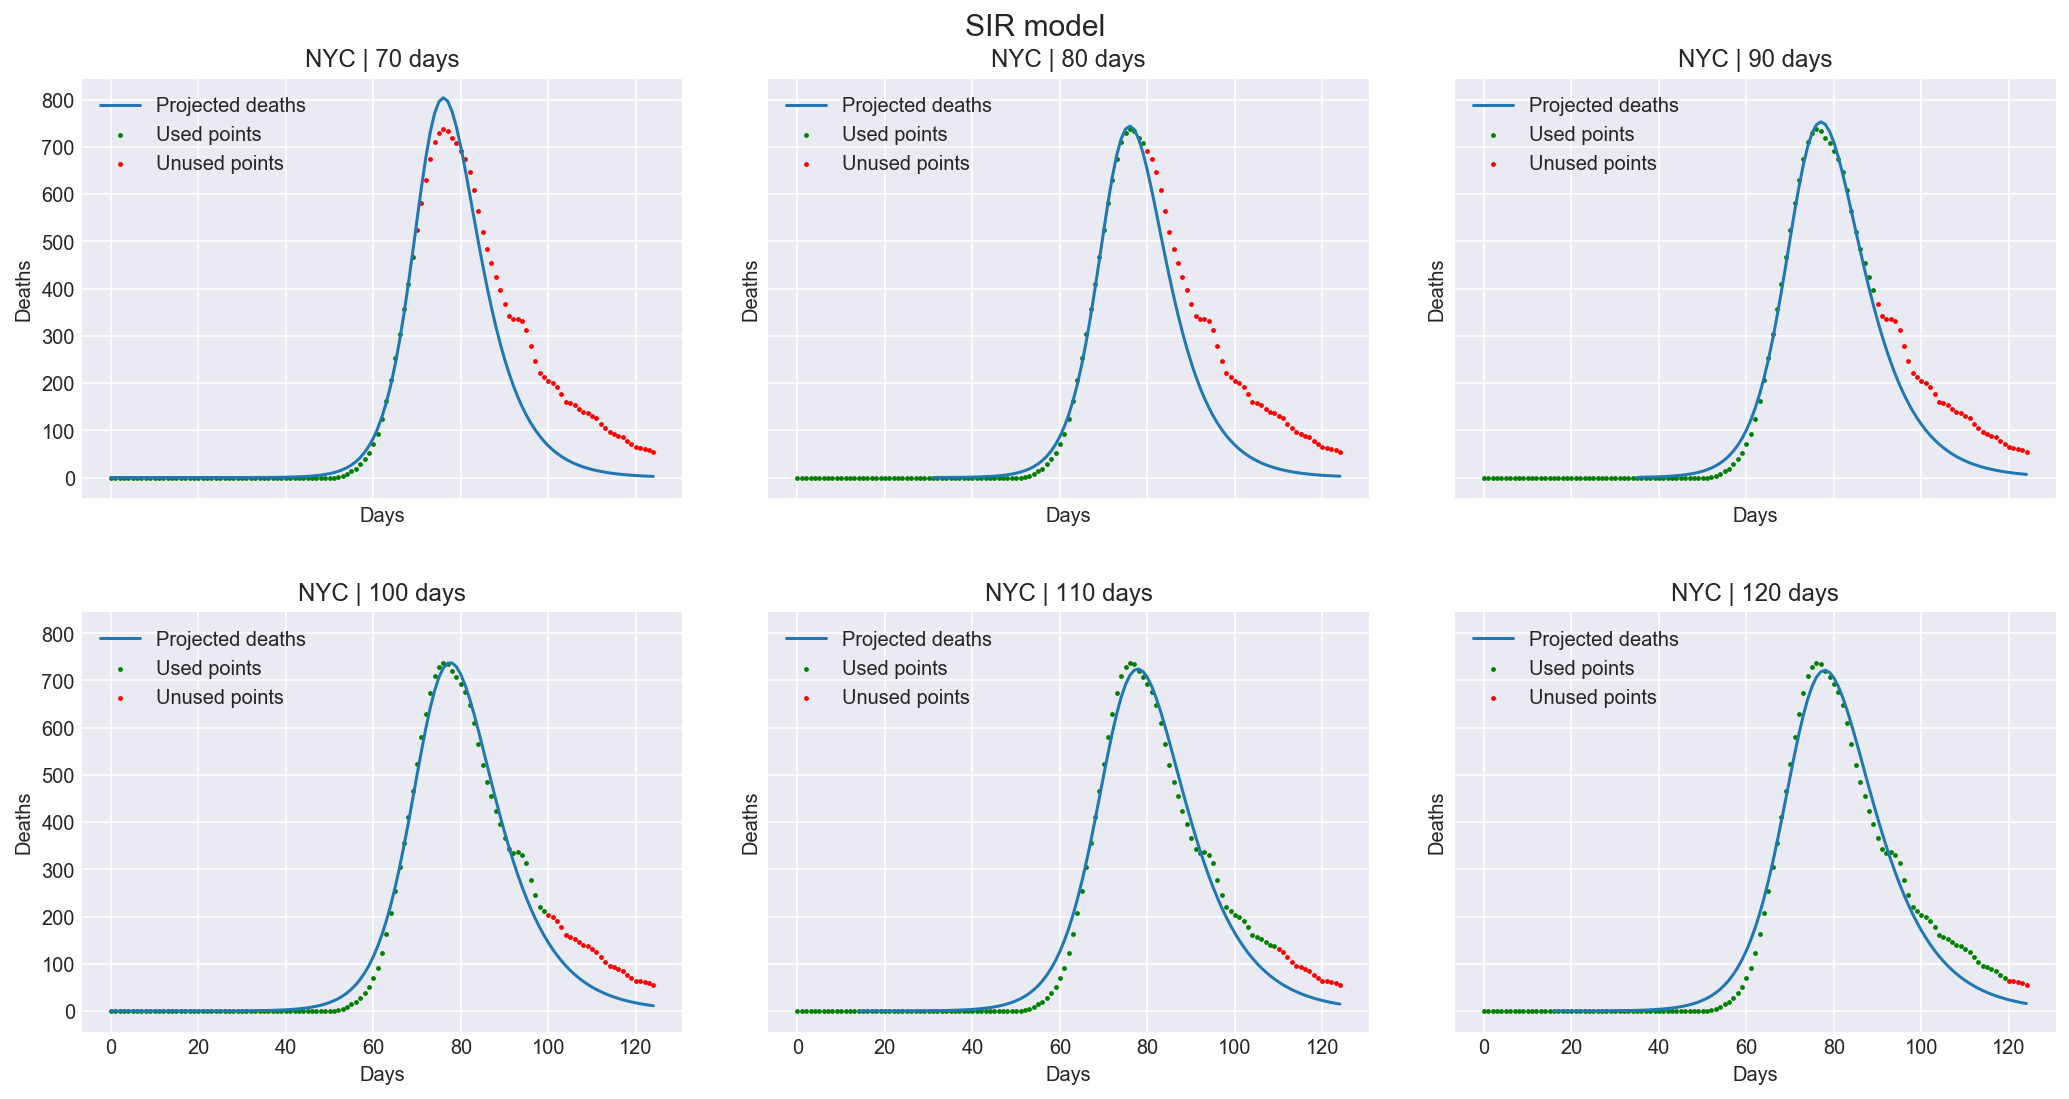

In [353]:
np.set_printoptions(formatter=lambda x: "{:.3E}".format(x))
get_model_stats(simple_sir, rmse_loss, smooth_data_nyc, range(70, 130, 10), "SIR model", 
                param_cols=["offset", "pop", "I_init", "R", "mort", "T_inf"],
                bounds=[(0, 50), (1e6, 8.4e6), (0, 1e-3), (1, 2.6), (0, 5e-2), (6, 8)])

<h2>Social distancing in NYC</h2>

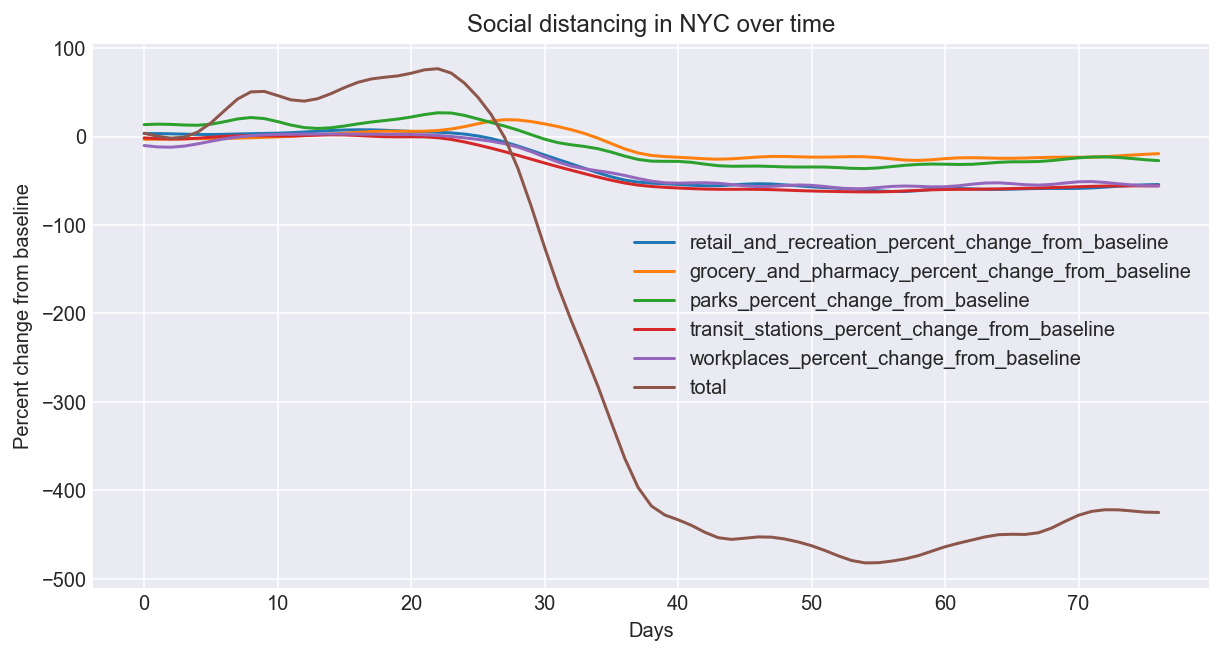

In [387]:
# Preprocess social distancing data from Google
start_date_sd = datetime.date(2020, 2, 15)
end_date_sd   = datetime.date(2020, 5, 1)
date_format_sd = "%Y-%m-%d"

df_sd = pd.read_csv("Global_Mobility_Report.csv")
df_sd = df_sd[df_sd['country_region_code'] == 'US']

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

# Counties which NYC covers -- population data from Wikipedia
counties = {"New York County" : 1628706, 
            "Kings County"    : 2559903, 
            "Bronx County"    : 1418207, 
            "Queens County"   : 2253858}

total_pop = 0.
for c in counties.keys():
    total_pop += counties[c]

agg_sd_nyc = {}
for cat in categories:
    agg_sd_nyc[cat] = []

curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    
    val = {}
    
    for c in counties.keys():
        df_county = df_sd_curr[df_sd_curr["sub_region_2"] == c]
        
        for cat in categories:
            if cat in val:
                val[cat] += counties[c] * np.array(df_county[cat])[0]
            else:
                val[cat] = counties[c] * np.array(df_county[cat])[0]
                
    for cat in categories:
        val[cat] /= total_pop
        agg_sd_nyc[cat].append(val[cat])
    
    curr_date = curr_date + datetime.timedelta(days=1)
    
agg_sd_nyc["total"] = np.zeros(len(agg_sd_nyc[categories[0]]))

# Get the total
for cat in agg_sd_nyc.keys():
    agg_sd_nyc[cat] = np.array(agg_sd_nyc[cat])
    agg_sd_nyc["total"] += agg_sd_nyc[cat]

# Plot the array
plt.figure(figsize=(10,5))
for label in agg_sd_nyc.keys():
    agg_sd_nyc[label] = smoothen(agg_sd_nyc[label], 2)
    plt.plot(agg_sd_nyc[label], label=label)

plt.title("Social distancing in NYC over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()